# Shadow removal with color clustering after shadow limiarization
This was the second try, in which the propose was to separate the scenario into lit and shadow regions and then clusterize each mask into regions according to the color distribution, separating the regions of ground, vegetation, sky and woods and finally remove them by enhancing the darker regions accordingly the lighter region's color distribution.

In [1]:
import numpy as np
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt

## Limiarization
To limiarize the image into lit and shadow regions, the luminance grayscale was used, i.e., the first step was to convert the color image (RGB) into a grayscale according to the luminance formula:

*luminance = 0.299 * R + 0.587 * G + 0.114 * B*

Text(0.5, 1.0, 'Luminance frame')

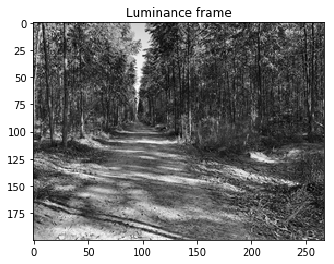

In [15]:
img = imageio.imread("../images/shadow5.jpg")

luminance_dataset = 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

plt.figure()
plt.imshow(luminance_dataset, cmap="gray");plt.title("Luminance frame")

In this second try, the limiarization was done by clustering the image into 2 groups, using the as initial centroids the minimum and maximum possible values of luminance.

With this approach, there is no scenario condition dependance for thresholding value.

In [3]:
# readjustment of range of values
def range_adjustment(img,minvalue=0,maxvalue=255):
    try:
        layers = img.shape[2]
    except:
        layers = 1
    
    img_u8 = np.zeros(img.shape, dtype=np.uint8)
    if(layers > 1):
        for z in range(layers):
            currmin = np.min(img[:,:,z])
            currmax = np.max(img[:,:,z])
            for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    img_u8[x,y,z] = ((img[x,y,z]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    else:
        currmin = np.min(img)
        currmax = np.max(img)
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                img_u8[x,y] = ((img[x,y]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    
    return img_u8 

In [4]:
# find the closest cluster to the example pixel
def closest_cluster(centroids, example):
    # calculate the euclidian distances of the example from all centroids
    distances = np.linalg.norm(np.subtract(centroids, example),axis=1)

    # return the cluster number in which there is the min distance value
    return (np.where(distances == np.min(distances))[0][0] + 1)

In [5]:
# after each iteration, the centroids coordinates are updated
def update_centroids(labeled_dataset, dataset, centroids):
    # for each centroid, compute the average values of all respective pixels attributes
    for c in range(centroids.shape[0]):
        # get all pixels that belongs to 'c' cluster
        cluster = dataset[np.where(labeled_dataset == c+1)]

        # compute the average of attributes values
        if(cluster.shape[0] != 0):
            centroids[c] = np.mean(cluster,axis=0)

    return centroids

In [26]:
# function to run the k-means routine in 'n' iterations
def kmeans_routine(dataset, centroids, k, n):
    r=centroids.shape[1]
    # create the frame for labeling the image
    label_img = np.zeros((dataset.shape[0],dataset.shape[1]), dtype=np.uint8)

    # loop to repeat 'n' times the iteration
    for iteration in range(n):
        # loops to run all dataset, labeling the objects according to centroids similarity
        for x in range(dataset.shape[0]):
            for y in range(dataset.shape[1]):
                if(np.sum(dataset[x,y]) == 0):
                    label_img[x,y] = 1
                else:
                    # collect an example object from dataset to be labeled
                    example = dataset[x,y]

                    # according to similarity, select the cluster in which the example belongs
                    cluster = closest_cluster(centroids, example)
                    # set the label_img pixel value to cluster's number
                    label_img[x,y] = cluster

        # update the centroids by calculating the average of attributes of each formed clusters
        centroids = update_centroids(label_img, dataset, centroids)
        
    return label_img

luminance_centroids = np.array([[np.min(luminance_dataset)], [np.max(luminance_dataset)]])

result = kmeans_routine(luminance_dataset, luminance_centroids, 2, 1)

lit_img = np.zeros(img.shape, dtype=np.uint8)
shadow_img = np.zeros(img.shape, dtype=np.uint8)

lit_img[np.where(result==2)] = img[np.where(result==2)]
shadow_img[np.where(result==1)] = img[np.where(result==1)]

As it was discussed on 1st try notebook, both shadow and lit areas have different color groups that separates sky, road, woods and green leafs. With that in mind, the next step is to clusterize them into these groups based on color and position.

Text(0.5, 1.0, 'shadow regions')

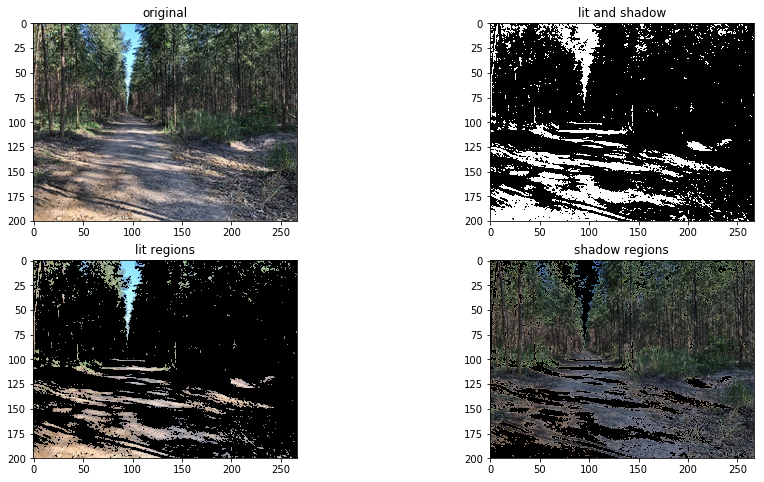

In [27]:
plt.figure(figsize=(15,8))
plt.subplot(221); plt.imshow(img); plt.title("original")
plt.subplot(222); plt.imshow(result,cmap="gray"); plt.title("lit and shadow")
plt.subplot(223); plt.imshow(lit_img); plt.title("lit regions")
plt.subplot(224); plt.imshow(shadow_img); plt.title("shadow regions")

In [7]:
def label_frame(frame, dataset, clusters):
    for i in range(1,np.max(clusters)+1):
        cluster = dataset[np.where(clusters == i)]
        coordinates = (cluster[:,-2],cluster[:,-1])
        frame[coordinates] = i
    
    return(frame)

## Clustering lit and shadow regions into color based clusters
For this step, it was considered the dataset composed by the attributes colors (R,G,B) and the pixel position (x,y coordinates).

Since the lit group has the sky (direct light)in blue color, the goal here is to cluster the lit areas into 4 subgroups: sky, road, forest in left side of road and forest in right side of forest.

On shadow group, on the other hand, has just 3 subgroups: road, forest in left side of road and forest in right side of road.

In [28]:
lit_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(result==2)
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
lit_dataset = np.dstack(([img[np.where(result == luminance_centroids.shape[0])]],
                           [coordinates]))


lit_centroids=np.array([[np.max(lit_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(lit_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(lit_dataset[:,:,1]),0,img.shape[0]//2,img.shape[1]-1],
                         [0,0,np.max(lit_dataset[:,:,2]),0,img.shape[1]//2]])

lit_clusters = kmeans_routine(lit_dataset, lit_centroids, 4, 3)

lit_mask = label_frame(lit_mask, lit_dataset, lit_clusters)


In [9]:
shadow_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(result==1)
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
shadow_dataset = np.dstack(([img[np.where(result == 1)]],
                           [coordinates]))

shadow_centroids=np.array([[np.max(shadow_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(shadow_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(shadow_dataset[:,:,1]),0,img.shape[0]//2,img.shape[1]-1]])

shadow_clusters = kmeans_routine(shadow_dataset, shadow_centroids, 3, 3)

shadow_mask = label_frame(shadow_mask, shadow_dataset, shadow_clusters)

So on lit regions, 4 centroids were created with attributes selected according to expected division.
For sky subgroup the centroid initial attributes were max value for blue layer and positioned at the middle top of frame, for road subgroup the initial attributes were the max value for red layer and positioned at the middle bottom of frame, and for the other two forests sides the initial attributes were the max value for green layer and positioned at the middle left and middle right of frame.

And on shadow regions, 3 centroids were created with initial attributes also selected according to expected division. For road subgroup the initial attributes were the max value for red layer and positioned at the middle bottom of frame, and for the other two forests sides the initial attributes were the max value for green layer and positioned at the middle left and middle right of frame.

Text(0.5, 1.0, 'shadow clusters')

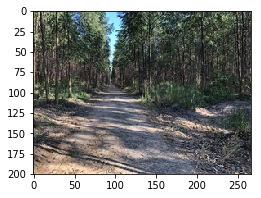

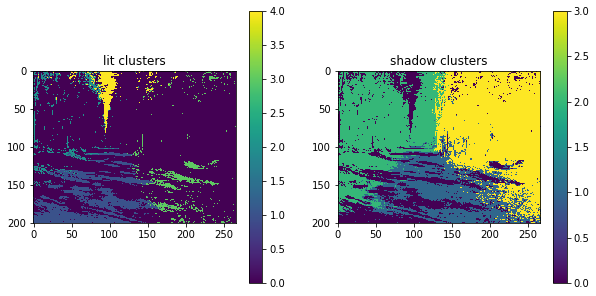

In [33]:
plt.figure(figsize=(10,3))
plt.imshow(img)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(lit_mask)
plt.colorbar()
plt.title("lit clusters")
plt.subplot(122)
plt.imshow(shadow_mask)
plt.colorbar()
plt.title("shadow clusters")

## Histogram equalization based on clusters
Once the shadow and lit regions are now clusterized into subgroups, the next step is to equalize the histogram based on each of these subgroups.

In other words, from previous step, the clusters on both groups (shadow and lit regions) were labeled as follow: label 1 is the road cluster, label 2 is the left forest, label 3 is the right forest, and the label 4 is the sky. 

With that in mind, for shadowed road it was taken the color distribution values on lit road subgroup as reference, and analoglously for the forests both side subgroups. 

Text(0.5, 1.0, 'result')

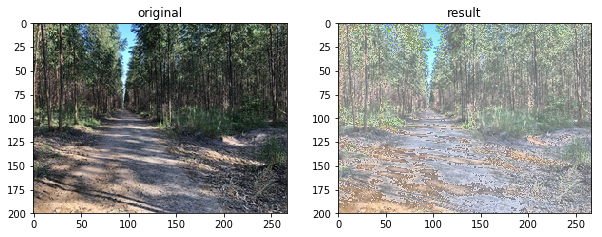

In [35]:
img_copy = np.copy(img)

for g in range(1,4):
    shadow_coordinates = np.where(shadow_mask==g)

    for c in range(3):
        unshadowmin = np.min(img[np.where(lit_mask==1)][:,0])
        unshadowmax = np.max(img[np.where(lit_mask==1)][:,0])
        shadowmin = np.min(img[np.where(shadow_mask==1)][:,0])
        shadowmax = np.max(img[np.where(shadow_mask==1)][:,0])
        for i in range(shadow_coordinates[0].shape[0]):
            x,y,z=shadow_coordinates[0][i],shadow_coordinates[1][i],c
            img_copy[x,y,z]=((float(img[x,y,z])-shadowmin)*(unshadowmax - unshadowmin)/(shadowmax - shadowmin)) + unshadowmin
    
plt.figure(figsize=(10,5))
plt.subplot(121);plt.imshow(img);plt.title("original")
plt.subplot(122);plt.imshow(img_copy);plt.title("result")

## Result and Discution
The result was still not good.
Analysing better the shadow and lit regions images, can be seen the reason of this unexpected result.

Because the original image was firstly divided only into 2 groups, the penumbra regions that exists on image was not considered, i.e., these penumbra regions were considered as lit regions of the road, in which there are high blue values too, producing the wrong result of color equalizing on road.

## Next step
Considering this analysis, the next try's first step was to clusteriz the image into 3 groups: lit, penumbra and umbra regions.